In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

folder = '../../data/training/dev/data'
plot_folder = 'plots/dev'

make_dir(plot_folder)

/Users/levinbrinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
metrics_df = pd.read_parquet(os.path.join(folder, 'metrics.parquet'))
confusion_matrix_df = pd.read_parquet(os.path.join(folder, 'confusion_matrix.parquet'))
synthethetic_df = pd.read_parquet(os.path.join(folder, 'synthetic_predicitions.parquet'))

metrics_df['shuffle_feature'] = metrics_df['shuffle_feature'].fillna('none')
confusion_matrix_df['shuffle_feature'] = confusion_matrix_df['shuffle_feature'].fillna('none')

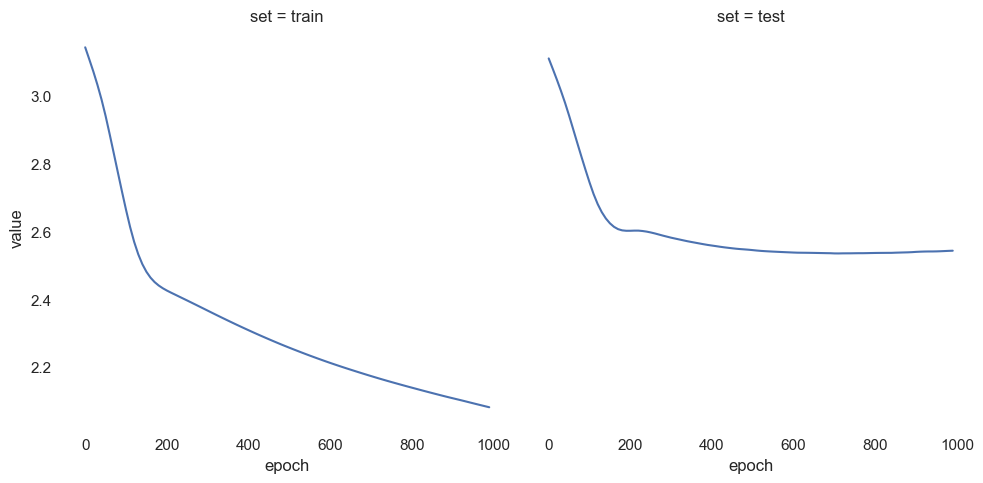

In [7]:
metric_name = 'log_loss'

# selection = best_labels[metric_name].copy()

selection = {
    'name': 'log_loss',
    'shuffle_feature': 'none'
}

focus = []

for f in focus:
    if f in selection:
        selection.pop(f)


w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.relplot(
    data=metrics_df[w1 & w2].copy(), 
    x='epoch', y='value',
    hue=focus[0] if len(focus) >= 1 else None, 
    style=focus[1] if len(focus) >= 2 else None,  
    col='set', row=focus[2] if len(focus) >= 3 else None, 
    kind='line', ci=None)

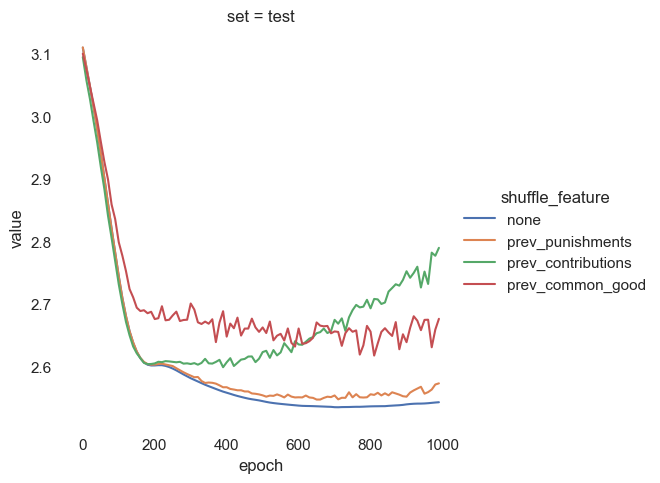

In [9]:
metric_name = 'log_loss'

# selection = best_labels[metric_name].copy()

selection = {
    'name': 'log_loss',
    'set': 'test'
}

focus = ['shuffle_feature']

for f in focus:
    if f in selection:
        selection.pop(f)

df = metrics_df[metrics_df['shuffle_feature'] == 'none']


w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.relplot(
    data=metrics_df[w1 & w2].copy(), 
    x='epoch', y='value',
    hue=focus[0] if len(focus) >= 1 else None, 
    style=focus[1] if len(focus) >= 2 else None,  
    col='set', row=focus[2] if len(focus) >= 3 else None, 
    kind='line', ci=None)

In [ ]:
def _plot_heatmap(data, x, y, values, normalise=True):
    dfg = data.groupby([x,y])[values].sum()
    dfg = dfg.reset_index()
    if normalise:
        dfg[values] = dfg[values] / dfg.groupby([x])[values].transform('sum')
    cm = dfg.pivot_table(index=x, columns=y, values=values)
    cm = cm.sort_index(ascending=False)
    sns.heatmap(cm)

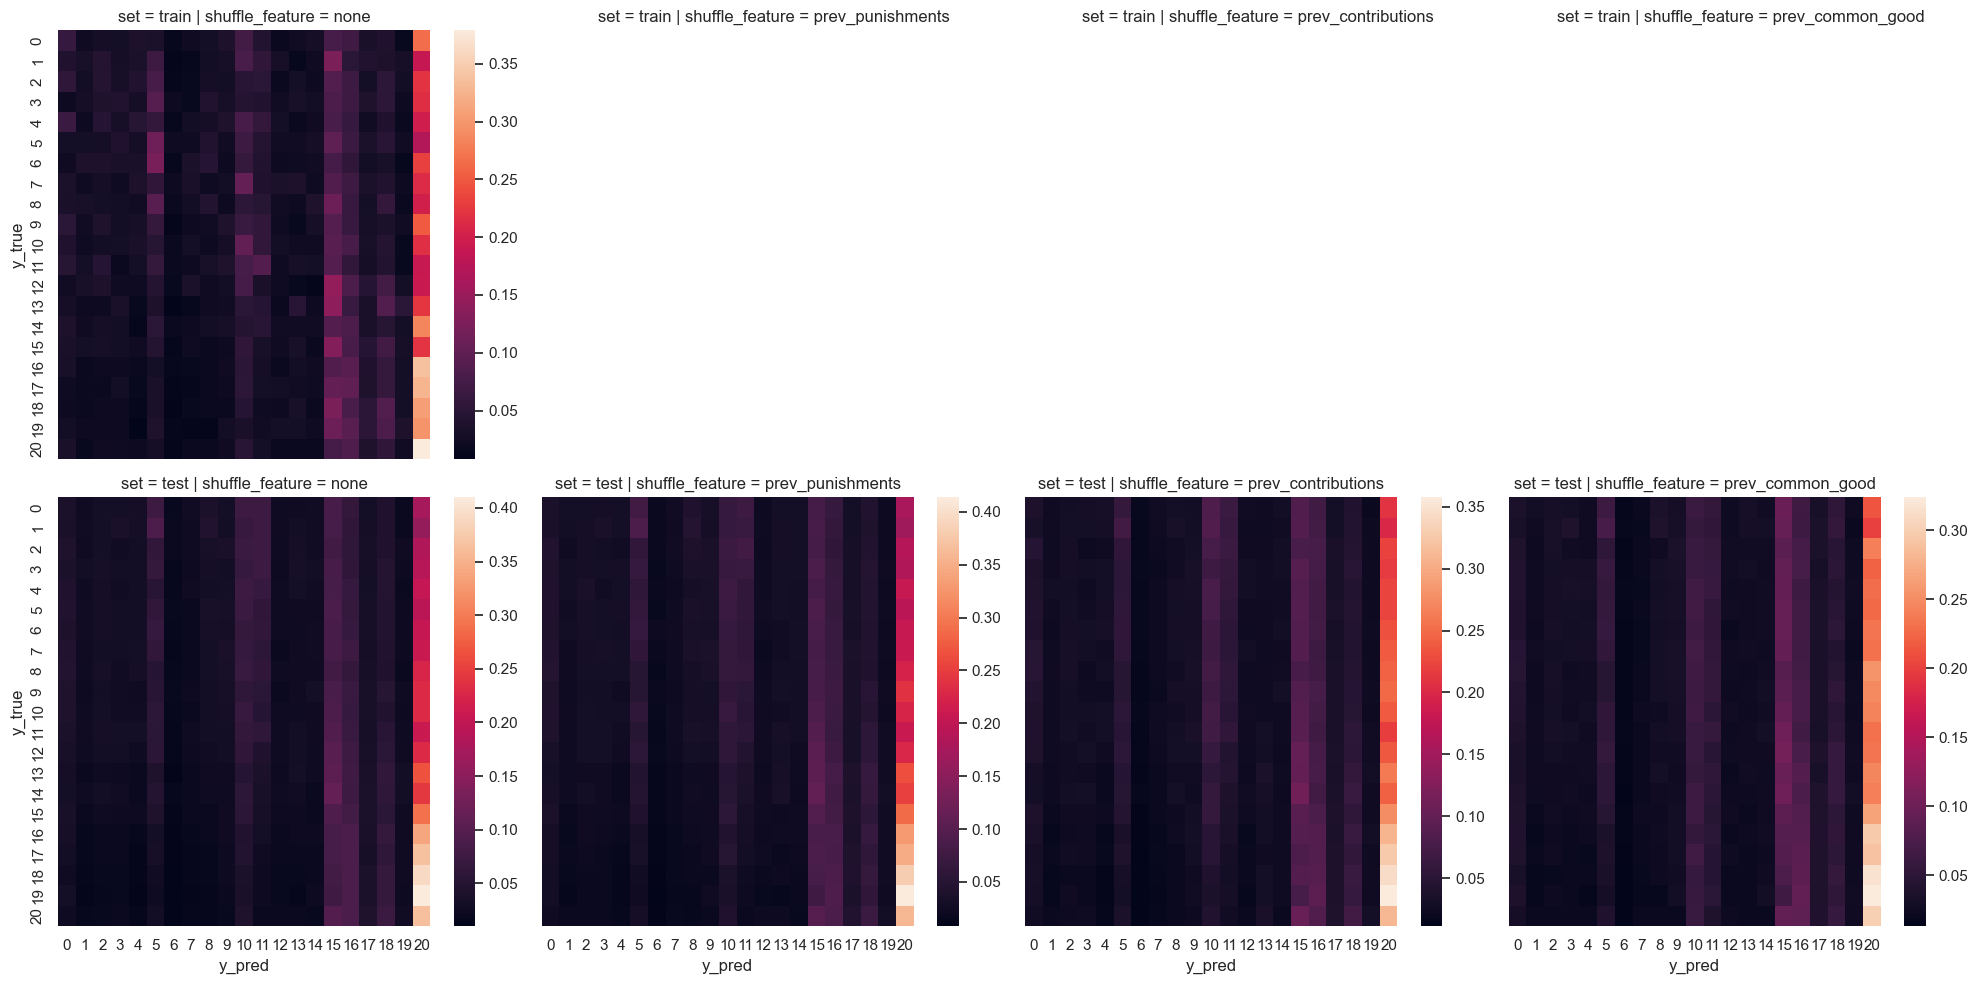

In [ ]:
df = confusion_matrix_df.copy()

w = (
    # (df['shuffle_feature'] == 'None') &
    (df['strategy'] == 'sampling') 
    # (df['set'] == 'test')
)

df = df[w]

focus_dimensions = ['shuffle_feature', 'set']


plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='y_true',y='y_pred', values='value')

fg = sns.FacetGrid(
    df, col=focus_dimensions[0] if len(focus_dimensions) > 0 else None,
    row=focus_dimensions[1] if len(focus_dimensions) > 1 else None,
    height=5)
fg.map_dataframe(plot_heatmap)

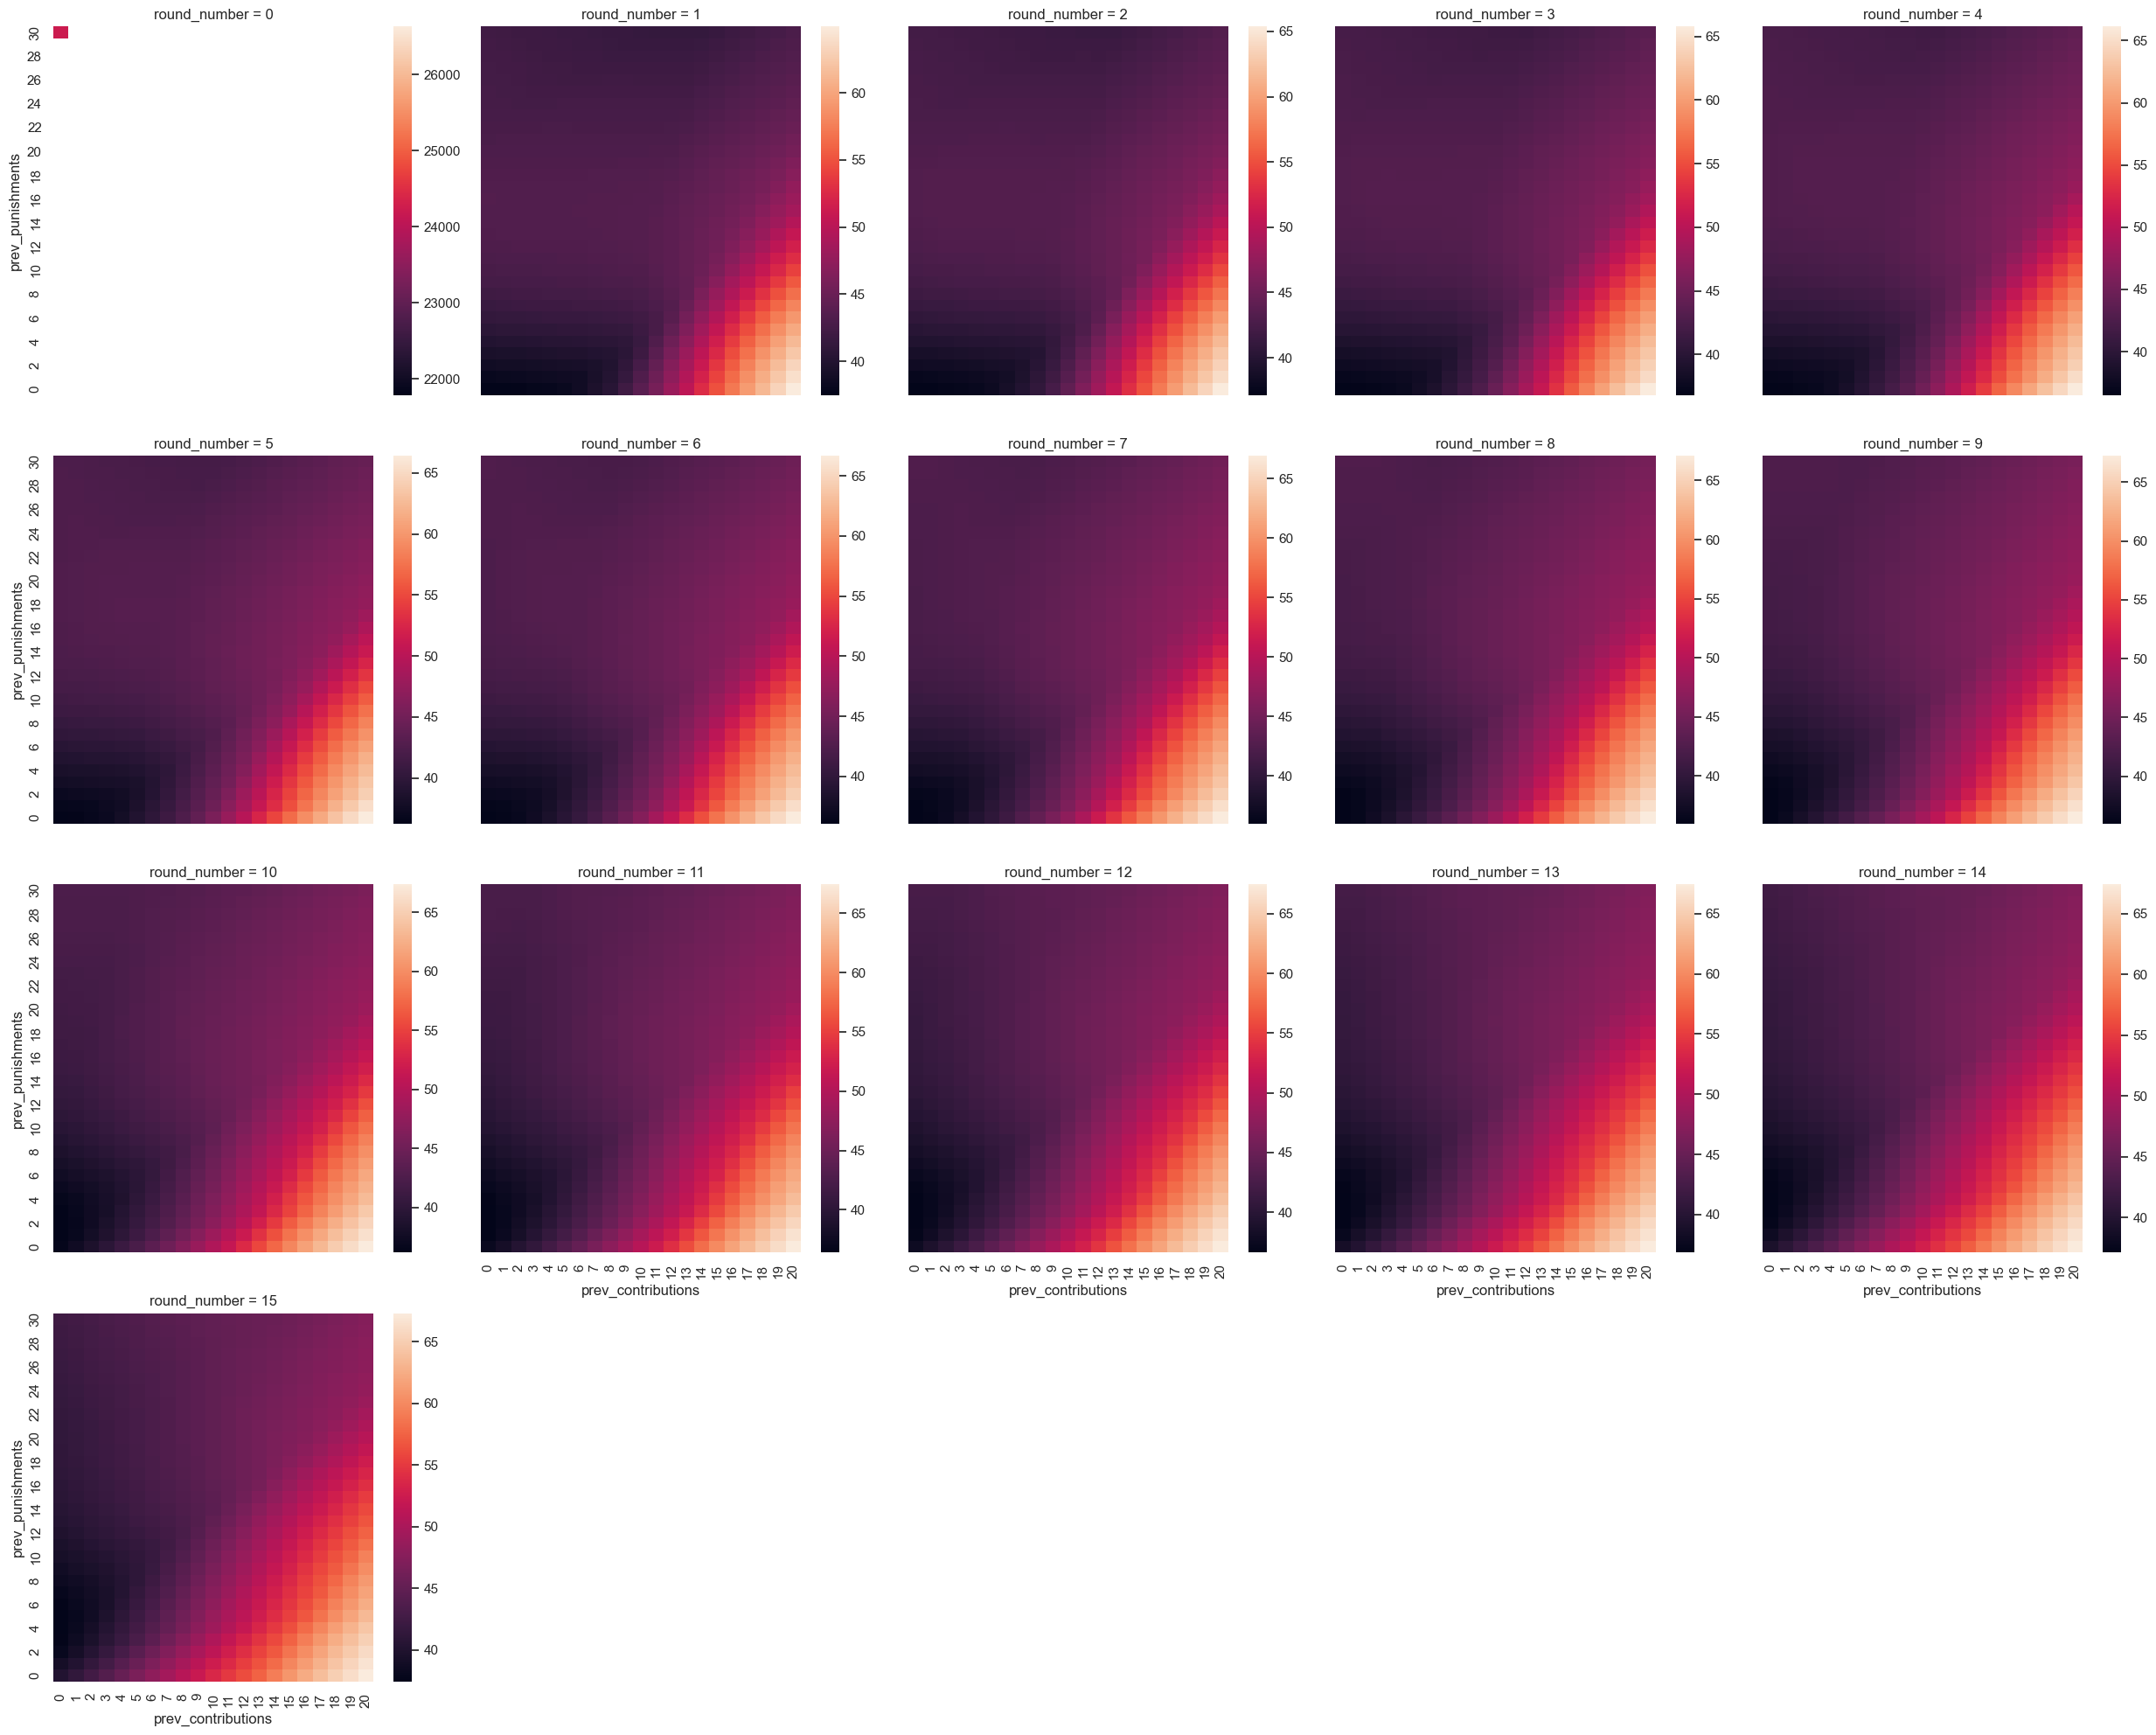

In [ ]:
df = synthethetic_df.groupby(['idx','round_number']).agg({'prev_contributions': 'first', 'prev_punishments': 'first', 'round_number': 'first', 'exp_contribution': 'mean'}).reset_index(drop=True)

# w = (
#     (df['shuffle_feature'] == 'None')
# )

# df = df[w]

focus_dimensions = ['round_number']


plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='prev_punishments',y='prev_contributions', values='exp_contribution', normalise=False)

fg = sns.FacetGrid(
    df, col=focus_dimensions[0] if len(focus_dimensions) > 0 else None,
    row=focus_dimensions[1] if len(focus_dimensions) > 1 else None,
    col_wrap=5 if len(focus_dimensions) < 2 else None,
    height=5)
fg.map_dataframe(plot_heatmap)